# Detection with CNNClassifier: CLAHE on V Channel 


In [1]:
from dotenv import load_dotenv

load_dotenv()

import sys
import os

sys.path.append(os.getenv('SRC_DIR'))

from utils.system import display_system_info

display_system_info(markdown=True)


**Last Updated**: 2025-04-29 01:06:42

**Python Version**: 3.11.8  
**OS**: Windows 10.0.26100  
**Architecture**: 64bit  
**Hostname**: Gan  
**Processor**: Intel64 Family 6 Model 186 Stepping 3, GenuineIntel  
**RAM Size**: 15.65 GB  
  
        

In [2]:
from torchvision import transforms
import torch
import cv2
from PIL import Image
import numpy as np

from classify import TorchClassifier

In [3]:
model_config = {
    'num_classes': 3,
    'num_blocks': 4,
    'first_out_channel': 32,
    'out_channel_multiplier': 2,
    'kernel_size': 3,
    'stride': 1,
    'padding': 1,
    'input_shape': (3, 128, 128)
}

model = TorchClassifier(model='CNNClassifier', config=model_config, device='auto', verbose=True)

New model created: CNNClassifier(
  (features): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, trac

In [4]:
class RGBToHSV:
    def __call__(self, img):
        # Ensure the image is in PIL format before converting
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)  # Convert tensor to PIL image
        
        # Convert the image to HSV using PIL
        img_hsv = img.convert("HSV")
        
        return img_hsv
    
class VClahe:
    def __call__(self, img):
        # Ensure the image is in PIL format
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)

        # Convert PIL image to NumPy array
        img_np = np.array(img)

        # Apply CLAHE on V channel
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        img_np[..., 2] = clahe.apply(img_np[..., 2])  # Modify only V channel

        # Convert NumPy array back to PIL Image in HSV mode
        img_hsv = Image.fromarray(img_np, mode='HSV')
        
        return img_hsv

aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1))
])

enhance_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    RGBToHSV(),
    VClahe(),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    RGBToHSV(),
    transforms.ToTensor()
])

In [5]:
results = model.train(
    data_path=os.getenv('ROI_DATA_DIR'),
    imbalance=True,
    fraction=1,
    val_test_ratio=0.5,
    input_size=128,
    optimizer='Adam',
    lr=1e-4,
    aug_transform=aug_transform,
    enhance_transform=enhance_transform,
    val_transform=val_transform,
    batch_size=32,
    epochs=5
) 

      Epoch       Loss   Accuracy    Macro(P          R        F1) Weighted(P          R        F1)


        1/5     0.3051      88.27     0.8828     0.8832     0.8829     0.8828     0.8832     0.8829: 100%|██████████| 552/552 [05:46<00:00,  1.59it/s]


                  Loss


                 0.256: 100%|██████████| 37/37 [00:07<00:00,  4.67it/s]


              precision    recall  f1-score   support

    drowning     0.9608    0.8077    0.8776       182
    swimming     0.9952    0.9014    0.9460       690
  treadwater     0.7361    0.9789    0.8404       285

    accuracy                         0.9058      1157
   macro avg     0.8974    0.8960    0.8880      1157
weighted avg     0.9260    0.9058    0.9092      1157

      Epoch       Loss   Accuracy    Macro(P          R        F1) Weighted(P          R        F1)


        2/5     0.1797       93.7     0.9374     0.9375     0.9375     0.9374     0.9375     0.9375: 100%|██████████| 552/552 [05:04<00:00,  1.82it/s]


                  Loss


                0.2964: 100%|██████████| 37/37 [00:07<00:00,  4.68it/s]


              precision    recall  f1-score   support

    drowning     0.9722    0.7692    0.8589       182
    swimming     0.9870    0.8797    0.9303       690
  treadwater     0.7136    0.9965    0.8316       285

    accuracy                         0.8911      1157
   macro avg     0.8909    0.8818    0.8736      1157
weighted avg     0.9173    0.8911    0.8947      1157

      Epoch       Loss   Accuracy    Macro(P          R        F1) Weighted(P          R        F1)


        3/5     0.1315      95.56     0.9562     0.9562     0.9562     0.9562     0.9562     0.9562: 100%|██████████| 552/552 [07:15<00:00,  1.27it/s]


                  Loss


                0.1707: 100%|██████████| 37/37 [00:20<00:00,  1.80it/s]


              precision    recall  f1-score   support

    drowning     0.9730    0.7912    0.8727       182
    swimming     0.9924    0.9507    0.9711       690
  treadwater     0.8103    0.9895    0.8910       285

    accuracy                         0.9352      1157
   macro avg     0.9253    0.9105    0.9116      1157
weighted avg     0.9445    0.9352    0.9359      1157

      Epoch       Loss   Accuracy    Macro(P          R        F1) Weighted(P          R        F1)


        4/5     0.1227      95.83     0.9589     0.9588     0.9588     0.9589     0.9588     0.9588: 100%|██████████| 552/552 [07:31<00:00,  1.22it/s]


                  Loss


                0.1633: 100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


              precision    recall  f1-score   support

    drowning     0.9551    0.8187    0.8817       182
    swimming     0.9939    0.9464    0.9696       690
  treadwater     0.8198    0.9895    0.8967       285

    accuracy                         0.9369      1157
   macro avg     0.9229    0.9182    0.9160      1157
weighted avg     0.9449    0.9369    0.9378      1157

      Epoch       Loss   Accuracy    Macro(P          R        F1) Weighted(P          R        F1)


        5/5      0.116       96.1     0.9616     0.9615     0.9616     0.9616     0.9615     0.9616: 100%|██████████| 552/552 [06:02<00:00,  1.52it/s]


                  Loss


                 0.143: 100%|██████████| 37/37 [00:09<00:00,  4.09it/s]

              precision    recall  f1-score   support

    drowning     0.9455    0.8571    0.8991       182
    swimming     0.9955    0.9551    0.9749       690
  treadwater     0.8515    0.9860    0.9138       285

    accuracy                         0.9473      1157
   macro avg     0.9308    0.9327    0.9293      1157
weighted avg     0.9521    0.9473    0.9479      1157



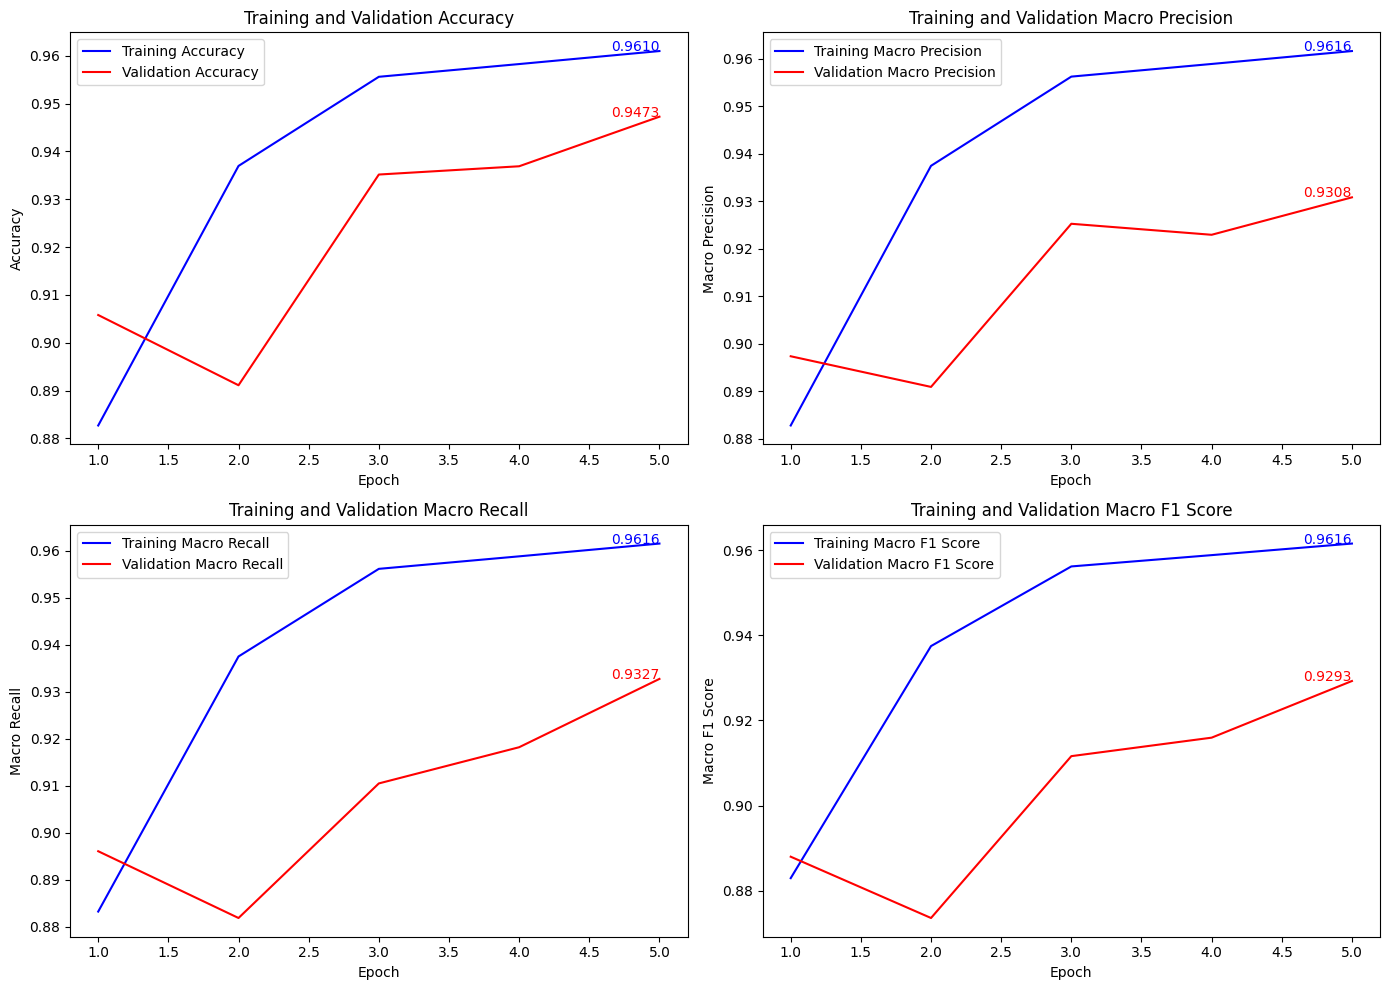

In [6]:
import matplotlib.pyplot as plt

# Split results into training and validation metrics
train_metrics, validation_metrics = results

# Extract training metrics
train_accuracy = [epoch['accuracy'] / 100 for epoch in train_metrics]
train_macro_precision = [epoch['macro_precision'] for epoch in train_metrics]
train_macro_recall = [epoch['macro_recall'] for epoch in train_metrics]
train_macro_f1 = [epoch['macro_f1'] for epoch in train_metrics]

# Extract validation metrics
validation_accuracy = [epoch['accuracy'] for epoch in validation_metrics]
validation_macro_precision = [epoch['macro avg']['precision'] for epoch in validation_metrics]
validation_macro_recall = [epoch['macro avg']['recall'] for epoch in validation_metrics]
validation_macro_f1 = [epoch['macro avg']['f1-score'] for epoch in validation_metrics]

# Create epoch list
epochs = range(1, len(train_accuracy) + 1)

# Set up the figure for 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # Wider figure
axs = axs.flatten()  # Flatten to easily index with a single number

# Plotting Accuracy
axs[0].plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
axs[0].plot(epochs, validation_accuracy, label='Validation Accuracy', color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()
axs[0].text(epochs[-1], train_accuracy[-1], f'{train_accuracy[-1]:.4f}', color='blue', fontsize=10, ha='right')
axs[0].text(epochs[-1], validation_accuracy[-1], f'{validation_accuracy[-1]:.4f}', color='red', fontsize=10, ha='right')

# Plotting Precision
axs[1].plot(epochs, train_macro_precision, label='Training Macro Precision', color='blue')
axs[1].plot(epochs, validation_macro_precision, label='Validation Macro Precision', color='red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Macro Precision')
axs[1].set_title('Training and Validation Macro Precision')
axs[1].legend()
axs[1].text(epochs[-1], train_macro_precision[-1], f'{train_macro_precision[-1]:.4f}', color='blue', fontsize=10, ha='right')
axs[1].text(epochs[-1], validation_macro_precision[-1], f'{validation_macro_precision[-1]:.4f}', color='red', fontsize=10, ha='right')

# Plotting Recall
axs[2].plot(epochs, train_macro_recall, label='Training Macro Recall', color='blue')
axs[2].plot(epochs, validation_macro_recall, label='Validation Macro Recall', color='red')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Macro Recall')
axs[2].set_title('Training and Validation Macro Recall')
axs[2].legend()
axs[2].text(epochs[-1], train_macro_recall[-1], f'{train_macro_recall[-1]:.4f}', color='blue', fontsize=10, ha='right')
axs[2].text(epochs[-1], validation_macro_recall[-1], f'{validation_macro_recall[-1]:.4f}', color='red', fontsize=10, ha='right')

# Plotting F1 Score
axs[3].plot(epochs, train_macro_f1, label='Training Macro F1 Score', color='blue')
axs[3].plot(epochs, validation_macro_f1, label='Validation Macro F1 Score', color='red')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Macro F1 Score')
axs[3].set_title('Training and Validation Macro F1 Score')
axs[3].legend()
axs[3].text(epochs[-1], train_macro_f1[-1], f'{train_macro_f1[-1]:.4f}', color='blue', fontsize=10, ha='right')
axs[3].text(epochs[-1], validation_macro_f1[-1], f'{validation_macro_f1[-1]:.4f}', color='red', fontsize=10, ha='right')

plt.tight_layout()
plt.show()


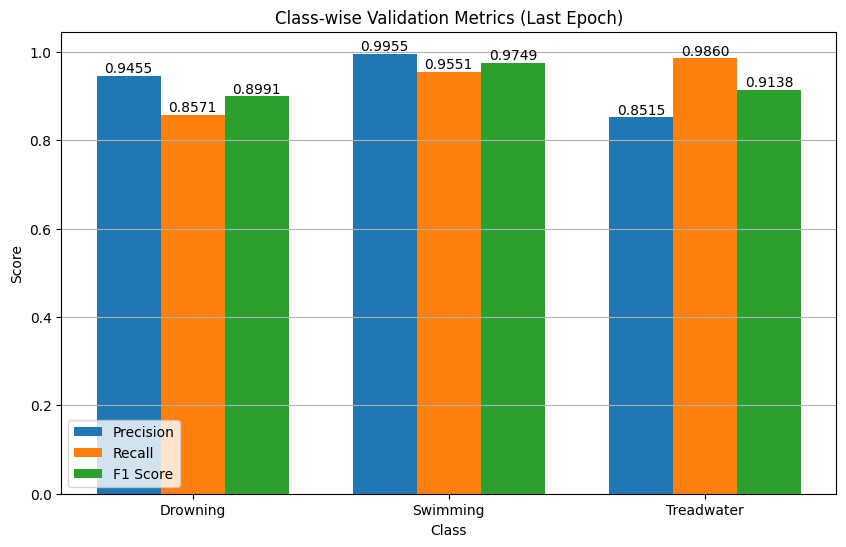

In [7]:
# Validation metrics (final epoch)
final_validation_metric = validation_metrics[-1]

# Extracting precision, recall, f1 for the three classes
classes = ['Drowning', 'Swimming', 'Treadwater']
precision = [final_validation_metric['drowning']['precision'],
             final_validation_metric['swimming']['precision'],
             final_validation_metric['treadwater']['precision']]

recall = [final_validation_metric['drowning']['recall'],
          final_validation_metric['swimming']['recall'],
          final_validation_metric['treadwater']['recall']]

f1_score = [final_validation_metric['drowning']['f1-score'],
            final_validation_metric['swimming']['f1-score'],
            final_validation_metric['treadwater']['f1-score']]

# Plotting classwise metrics (Precision, Recall, F1-Score)
x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
bars_precision = ax.bar(x - width, precision, width, label='Precision')
bars_recall = ax.bar(x, recall, width, label='Recall')
bars_f1 = ax.bar(x + width, f1_score, width, label='F1 Score')

# Add values on top of each bar
for bar in bars_precision:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

for bar in bars_recall:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

for bar in bars_f1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Class-wise Validation Metrics (Last Epoch)')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
ax.grid(axis='y')

# Display the plot
plt.show()

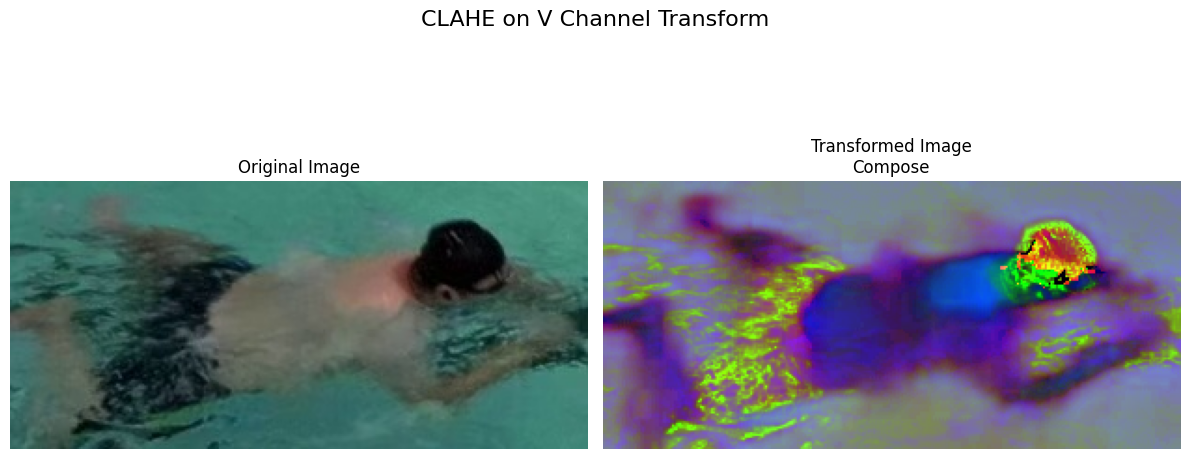

In [8]:
def visualize_transform(image, transform, figsize=(12, 6), title=None):
    # Convert input to PIL Image
    if isinstance(image, np.ndarray):
        image = Image.fromarray(np.uint8(image))
    elif isinstance(image, torch.Tensor):
        if image.dim() == 4:  # batch of images
            image = image[0]  # take first image from batch
        if image.shape[0] in [1, 3]:  # if channel-first format (C,H,W)
            image = image.permute(1, 2, 0)  # change to (H,W,C)
        image = Image.fromarray(np.uint8(image.numpy() * 255))

    # Apply transformation
    try:
        transformed_image = transform(image)
    except Exception as e:
        print(f"Error applying transformation: {e}")
        return None

    # Convert transformed image to numpy array if it's a tensor
    if isinstance(transformed_image, torch.Tensor):
        if transformed_image.dim() == 4:  # batch of images
            transformed_image = transformed_image[0]  # take first image from batch
        if transformed_image.shape[0] in [1, 3]:  # if channel-first format (C,H,W)
            transformed_image = transformed_image.permute(1, 2, 0)  # change to (H,W,C)
        transformed_image = transformed_image.numpy()

        # If image has values in [0,1], scale to [0,255]
        if transformed_image.max() <= 1.0:
            transformed_image = transformed_image * 255

        transformed_image = np.uint8(transformed_image)
        transformed_image = Image.fromarray(transformed_image)

    # Create the figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Set the main title if provided
    if title:
        fig.suptitle(title, fontsize=16)

    # Plot original image
    axes[0].imshow(np.array(image))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot transformed image
    axes[1].imshow(np.array(transformed_image))
    axes[1].set_title(f'Transformed Image\n{transform.__class__.__name__}')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

visualise_transform = transforms.Compose([
    RGBToHSV(),
    VClahe(),
    transforms.ToTensor()
])

img_for_vis = Image.open(os.path.join(os.getenv('ROI_DATA_DIR'), 'train', 'swimming', '000000.jpg'))
visualize_transform(img_for_vis, visualise_transform, title='CLAHE on V Channel Transform')

In [9]:
model.save(
    os.path.join(os.getenv('CNN_MODEL_DIR'), 'try_clahe.pt')
)

Model saved to C:\Users\hp\Downloads\Drowning-Detection/models/classification/CNN\try_clahe.pt


In [10]:
# Add model prediction here
loaded_model = TorchClassifier(model='CNNClassifier', model_path=os.path.join(os.getenv('CNN_MODEL_DIR'), 'try_clahe.pt'), device='auto', verbose=False)

img = Image.open(rf'C:\Users\hp\Downloads\Drowning-Detection\data\roi\val\drowning\{str(63).zfill(6)}.jpg')

prediction = loaded_model(
    img=img,
    transform=val_transform,
    prob=True
).cpu().numpy()

IDX_TO_CLASS2 = {
    0: 'drowning',
    1: 'swimming',
    2: 'treadwater'
}

print(prediction)
print(IDX_TO_CLASS2[np.argmax(prediction)])

loaded_model_results = loaded_model.validate(
    data_path=os.getenv('ROI_DATA_DIR'),
    transform=val_transform,
    val_test_ratio=0.5
)

[0.5541016  0.01800428 0.4278941 ]
drowning


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

Validation: 100%|██████████| 37/37 [00:09<00:00,  4.06it/s]

              precision    recall  f1-score   support

    drowning     0.9653    0.9176    0.9408       182
    swimming     0.9939    0.9493    0.9711       690
  treadwater     0.8492    0.9684    0.9049       285

    accuracy                         0.9490      1157
   macro avg     0.9362    0.9451    0.9390      1157
weighted avg     0.9538    0.9490    0.9500      1157

